In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

In [2]:
train_data = '/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/nd-twins-0006/train'

In [3]:
# class TwinDataset(Dataset):
#     def __init__(self, dataroot, df, transform):
#         '''
#         dataroot: path to folder with items
#         df: pandas dataframe with fields view, id_a, id_b
#         transform: torchvision transform
#         '''
#         self.dataroot = dataroot
#         self.df = df
#         self.transform = transform
        
#     def __getitem__(self, index):
#         def get_img_path(img_id, view):
#             return os.path.join(self.dataroot, f'{img_id}/{img_id}d{view}__face.jpg')
        
#         views, id_a, id_b  = self.df.iloc[index].values
        
#         view = np.random.choice(views)
# #         print(view, id_a, id_b)
#         path_a = get_img_path(id_a, view)
#         path_b = get_img_path(id_b, view)
        
#         img_a = Image.open(path_a)
#         img_b = Image.open(path_b)
        
#         img_a = self.transform(img_a)
#         img_b = self.transform(img_b)
        
#         return {'A': img_a, 'B': img_b, 'A_paths': path_a, 'B_paths': path_b }
    
#     def __len__(self):
#         return self.df.shape[0]

In [4]:
# twins_dataset = TwinDataset(f'{datadir}/faces', df_train, base_transform)
# # dataset = dataloader  # create a dataset given opt.dataset_mode and other options
# dataset = DataLoader(twins_dataset,
#             batch_size=opt.batch_size,
#             shuffle=not opt.serial_batches)

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
         transforms.CenterCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/nd-twins-0006/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

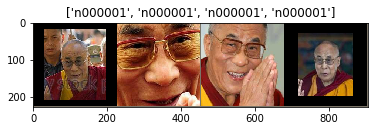

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
from model import MobileFaceNet

device = torch.device('cuda:1')

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"model_mobilefacenet.pth")

checkpoint = torch.load(PATH,map_location=device)

model.load_state_dict(checkpoint)

optimizer = optim.SGD(model.parameters(),lr=0.1)

### Testing the shape of the output after flatten_layer

In [11]:
## This class for choosing the layers you need
class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        x = self.features(x)
        return x


model_flatten = ModelBottom(model)
inputs, labels = next(iter(dataloaders['train']))
outputs = model_flatten(inputs)
outputs.data.shape  

torch.Size([4, 32768])

### Define num of labels

In [13]:
os.listdir(train_data)

['n000009', 'n000001', '__pycache__', 'n000040', '.pytest_cache', 'n000029']

In [16]:
hid_size = outputs.data.shape[1]
n_classes = len(os.listdir(train_data))-2

In [17]:
# Freeze model weights
for param in model_flatten.parameters():
    param.requires_grad = False

### Add additional modules for classification

In [23]:
model_flatten.classifier = nn.Sequential(
                      nn.Linear(hid_size, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

In [24]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [25]:
total_params = sum(p.numel() for p in model_flatten.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_flatten.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')


9,327,236 total parameters.
8,389,892 training parameters.


In [26]:
model_ft = model_flatten.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [28]:
# inputs = inputs.cuda(device)
# labels = labels.cuda(device)
# preds = 
# loss = criterion(inputs, labels)
# loss.backward()

In [29]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)